# 实验4：决策树与集成学习（随机森林）

本 Notebook 实现了：

1. **自实现决策树分类器（CART，基尼指数）**，并在 Adult 数据集上测试；
2. **自实现随机森林分类器（Bagging + 随机特征子集）**；
3. 对比 `sklearn` 中对应模型的性能；
4. 通过 **可视化** 展示不同模型与参数设置下的分类效果差异。


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline


## 一、自实现决策树分类器（CART）

下面实现一个简单的 CART 决策树分类器，使用 **基尼指数 (Gini)** 作为划分标准，支持：

- 连续与离散特征（通过数值化实现）；
- 设置最大深度、最小划分样本数、最小叶子节点样本数等超参数。


In [14]:
import numpy as np

class MyDecisionTreeClassifier:
    """
    CART 决策树（分类）
    - 使用 Gini 指数
    - 支持 max_features：在每个结点随机选一部分特征划分
    - 支持 random_state：可复现
    """
    def __init__(
        self,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_impurity_decrease=0.0,
        max_features=None,          # 新增
        random_state=None           # 新增
    ):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease
        self.max_features = max_features
        self.random_state = random_state

        self.n_classes_ = None
        self.n_features_ = None
        self.tree_ = None
        self._rng = None

    class Node:
        def __init__(self, gini, num_samples, num_samples_per_class,
                     predicted_class):
            self.gini = gini
            self.num_samples = num_samples
            self.num_samples_per_class = num_samples_per_class
            self.predicted_class = predicted_class
            self.feature_index = None
            self.threshold = None
            self.left = None
            self.right = None

    # ---------- 一些工具函数 ----------
    def _init_rng(self):
        if self.random_state is None:
            self._rng = np.random
        else:
            self._rng = np.random.RandomState(self.random_state)

    def _gini(self, y):
        m = y.size
        if m == 0:
            return 0.0
        _, counts = np.unique(y, return_counts=True)
        p = counts / m
        return 1.0 - np.sum(p ** 2)

    def _get_n_sub_features(self, n_features):
        """根据 max_features 计算每个结点要使用的特征数"""
        if self.max_features is None:
            return n_features
        if isinstance(self.max_features, int):
            return max(1, min(self.max_features, n_features))
        if self.max_features == "sqrt":
            return max(1, int(np.sqrt(n_features)))
        if self.max_features == "log2":
            return max(1, int(np.log2(n_features)))
        # 其他非法写法就退化为全部特征
        return n_features

    def _best_split(self, X, y):
        """在当前结点上寻找最优划分特征和阈值"""
        m, n = X.shape
        if m < self.min_samples_split:
            return None, None

        best_gini = 1.0
        best_idx, best_thr = None, None
        parent_gini = self._gini(y)

        # 关键修改：在每个结点随机选一部分特征
        n_sub_features = self._get_n_sub_features(n)
        feat_indices = np.arange(n)
        if n_sub_features < n:
            feat_indices = self._rng.choice(n, n_sub_features, replace=False)

        for idx in feat_indices:
            sorted_idx = np.argsort(X[:, idx])
            X_sorted = X[sorted_idx, idx]
            y_sorted = y[sorted_idx]

            num_left = np.zeros(self.n_classes_, dtype=int)
            _, counts_total = np.unique(y_sorted, return_counts=True)
            num_right = counts_total.copy()

            for i in range(1, m):
                c = y_sorted[i - 1]
                num_left[c] += 1
                num_right[c] -= 1

                if X_sorted[i] == X_sorted[i - 1]:
                    continue

                if i < self.min_samples_leaf or (m - i) < self.min_samples_leaf:
                    continue

                gini_left = 1.0 - np.sum((num_left[:] / i) ** 2)
                gini_right = 1.0 - np.sum((num_right[:] / (m - i)) ** 2)
                gini = (i * gini_left + (m - i) * gini_right) / m

                if gini < best_gini and (parent_gini - gini) >= self.min_impurity_decrease:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (X_sorted[i] + X_sorted[i - 1]) / 2.0

        return best_idx, best_thr

    def _grow_tree(self, X, y, depth):
        num_samples_per_class = np.bincount(y, minlength=self.n_classes_)
        predicted_class = np.argmax(num_samples_per_class)
        node = self.Node(
            gini=self._gini(y),
            num_samples=y.size,
            num_samples_per_class=num_samples_per_class,
            predicted_class=predicted_class,
        )

        if (self.max_depth is not None and depth >= self.max_depth) or \
           node.gini == 0.0 or \
           y.size < self.min_samples_split:
            return node

        idx, thr = self._best_split(X, y)
        if idx is None:
            return node

        indices_left = X[:, idx] <= thr
        X_left, y_left = X[indices_left], y[indices_left]
        X_right, y_right = X[~indices_left], y[~indices_left]

        if y_left.size == 0 or y_right.size == 0:
            return node

        node.feature_index = idx
        node.threshold = thr
        node.left = self._grow_tree(X_left, y_left, depth + 1)
        node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node

    # ---------- 公共接口 ----------
    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        self._init_rng()
        self.tree_ = self._grow_tree(X, y, depth=0)
        return self

    def _predict_inputs(self, inputs):
        node = self.tree_
        while node.left is not None and node.right is not None:
            if inputs[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

    def predict(self, X):
        X = np.asarray(X)
        return np.array([self._predict_inputs(row) for row in X])



## 二、Adult 数据集加载与预处理

Adult 数据集是一个经典的收入预测数据集，目标是预测 `income` 是否大于 `50K`。

> 注意：本单元使用 `fetch_openml` 从网络下载数据，首次运行需要联网。


In [15]:
# 1) 加载 Adult 数据集
adult = fetch_openml(name="adult", version=2, as_frame=True)
X = adult.data.copy()
y = adult.target.copy()

print("原始数据维度:", X.shape)
X.head()


原始数据维度: (48842, 14)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States


In [16]:
# 2) 特征预处理：
#    - 类别特征：LabelEncoder 编码；缺失值填为 "Unknown"；
#    - 数值特征：缺失值填为中位数。

X_processed = X.copy()
encoders_X = {}

for col in X_processed.columns:
    if X_processed[col].dtype == "object" or str(X_processed[col].dtype) == "category":
        X_processed[col] = X_processed[col].astype("category")
        if "Unknown" not in X_processed[col].cat.categories:
            X_processed[col] = X_processed[col].cat.add_categories("Unknown")
        X_processed[col] = X_processed[col].fillna("Unknown")
        le = LabelEncoder()
        X_processed[col] = le.fit_transform(X_processed[col])
        encoders_X[col] = le
    else:
        X_processed[col] = X_processed[col].astype(float)
        X_processed[col] = X_processed[col].fillna(X_processed[col].median())

# 3) 标签处理
y = y.astype("category")
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

# 4) 划分训练 / 测试集
X_train, X_test, y_train, y_test = train_test_split(
    X_processed.values, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Train shape: (39073, 14)  Test shape: (9769, 14)


## 三、自实现决策树 vs Sklearn 决策树

在相同的超参数设置下，对比两种实现的测试集准确率，并给出可视化柱状图。


In [17]:
# 训练自实现决策树
my_tree = MyDecisionTreeClassifier(
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5
)
my_tree.fit(X_train, y_train)
y_pred_my_tree = my_tree.predict(X_test)
acc_my_tree = accuracy_score(y_test, y_pred_my_tree)
print(f"MyDecisionTree Test Accuracy: {acc_my_tree:.4f}")

# Sklearn 决策树
sk_tree = DecisionTreeClassifier(
    criterion="gini",
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
sk_tree.fit(X_train, y_train)
y_pred_sk_tree = sk_tree.predict(X_test)
acc_sk_tree = accuracy_score(y_test, y_pred_sk_tree)
print(f"Sklearn DecisionTree Test Accuracy: {acc_sk_tree:.4f}")


MyDecisionTree Test Accuracy: 0.8586
Sklearn DecisionTree Test Accuracy: 0.8590


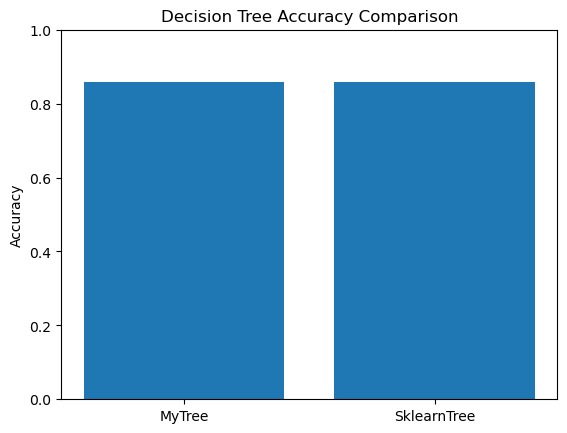

In [18]:
# 可视化：对比两个决策树的测试准确率
plt.figure()
models = ["MyTree", "SklearnTree"]
accs = [acc_my_tree, acc_sk_tree]
x = np.arange(len(models))
plt.bar(x, accs)
plt.xticks(x, models)
plt.ylabel("Accuracy")
plt.title("Decision Tree Accuracy Comparison")
plt.ylim(0, 1)
plt.show()


## 四、自实现随机森林分类器

在自实现决策树的基础上，构造随机森林：

- 采用 **Bootstrap 自助采样** 构建多个训练子集；
- 每棵树在划分结点时仅考虑一个随机的特征子集（`max_features`）；
- 最终预测使用多棵树的 **多数表决**。


In [19]:
class MyRandomForestClassifier:
    """
    随机森林（分类）
    - Bootstrap 采样样本
    - 基学习器：上面的 MyDecisionTreeClassifier
      * 每个结点随机选择 max_features 个特征划分
    """
    def __init__(
        self,
        n_estimators=50,
        max_depth=None,
        max_features="sqrt",
        bootstrap=True,
        min_samples_split=2,
        min_samples_leaf=1,
        min_impurity_decrease=0.0,
        random_state=None,
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease
        self.random_state = random_state

        self.trees_ = []
        self.n_classes_ = None

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        n_samples, n_features = X.shape
        self.n_classes_ = len(np.unique(y))
        self.trees_ = []

        rng = np.random.RandomState(self.random_state) if self.random_state is not None else np.random

        for i in range(self.n_estimators):
            # 1) bootstrap 抽样
            if self.bootstrap:
                indices = rng.randint(0, n_samples, n_samples)
            else:
                indices = np.arange(n_samples)
            X_boot = X[indices]
            y_boot = y[indices]

            # 2) 训练一棵决策树（注意：树内部会在每个结点随机选特征）
            tree = MyDecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                min_impurity_decrease=self.min_impurity_decrease,
                max_features=self.max_features,
                random_state=None if self.random_state is None else self.random_state + i
            )
            tree.fit(X_boot, y_boot)
            self.trees_.append(tree)

        return self

    def predict(self, X):
        X = np.asarray(X)
        n_samples = X.shape[0]
        all_preds = np.zeros((n_samples, len(self.trees_)), dtype=int)

        for i, tree in enumerate(self.trees_):
            all_preds[:, i] = tree.predict(X)

        # 多数表决
        y_pred = np.zeros(n_samples, dtype=int)
        for i in range(n_samples):
            counts = np.bincount(all_preds[i], minlength=self.n_classes_)
            y_pred[i] = np.argmax(counts)
        return y_pred

    def score(self, X, y):
        from sklearn.metrics import accuracy_score
        return accuracy_score(y, self.predict(X))


### 4.1 自实现随机森林 vs Sklearn 随机森林 and 单棵决策树


In [ ]:
# 自实现随机森林
my_rf = MyRandomForestClassifier(
    n_estimators=30,
    max_depth=10,
    max_features="sqrt",
    bootstrap=True,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
my_rf.fit(X_train, y_train)
y_pred_my_rf = my_rf.predict(X_test)
acc_my_rf = accuracy_score(y_test, y_pred_my_rf)
print(f"MyRandomForest Test Accuracy: {acc_my_rf:.4f}")

# Sklearn 随机森林
sk_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    max_features="sqrt",
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
sk_rf.fit(X_train, y_train)
y_pred_sk_rf = sk_rf.predict(X_test)
acc_sk_rf = accuracy_score(y_test, y_pred_sk_rf)
print(f"Sklearn RandomForest Test Accuracy: {acc_sk_rf:.4f}")
print(f"Improvement of the Random Forest than the Decision Tree: {(acc_my_rf - acc_my_tree):.4f}")


MyRandomForest Test Accuracy: 0.8607
Sklearn RandomForest Test Accuracy: 0.8619


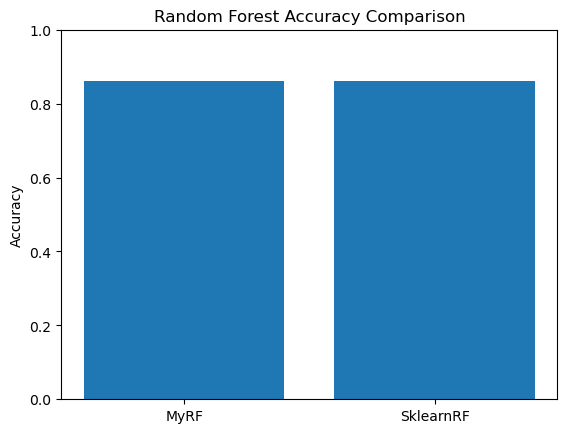

In [21]:
# 可视化：对比两个随机森林的测试准确率
plt.figure()
models = ["MyRF", "SklearnRF"]
accs = [acc_my_rf, acc_sk_rf]
x = np.arange(len(models))
plt.bar(x, accs)
plt.xticks(x, models)
plt.ylabel("Accuracy")
plt.title("Random Forest Accuracy Comparison")
plt.ylim(0, 1)
plt.show()


### 4.2 基学习器数量与特征子集策略对性能的影响

下面固定其他参数，改变：

- 随机森林中树的数量 `n_estimators`；
- 特征子集策略 `max_features`（取 "sqrt" 与 "log2"）；

观察其对测试集准确率的影响，并通过折线图展示。


In [25]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score

# 定义与实验文档类似的基学习器数量列表
n_estimators_list = [1, 2, 3, 4] + [5 * (i + 1) for i in range(10)]  # 1,2,3,4,5,10,...,100

accuracies_sqrt = []
accuracies_log2 = []

for n_estimators in n_estimators_list:
    # max_features = "sqrt"
    print(f"handling case{n_estimators}")
    rf_sqrt = MyRandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=None,          # 放开树深度，让基学习器更强
        max_features="sqrt",
        bootstrap=True,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=1           # 固定种子，便于复现实验
    )
    rf_sqrt.fit(X_train, y_train)
    y_pred_sqrt = rf_sqrt.predict(X_test)
    acc_sqrt = accuracy_score(y_test, y_pred_sqrt)
    accuracies_sqrt.append(acc_sqrt)
    print(f"acc_sqrt{acc_sqrt}")

    # max_features = "log2"
    rf_log2 = MyRandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=None,
        max_features="log2",
        bootstrap=True,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=1           # 同一个种子，方便比较
    )
    rf_log2.fit(X_train, y_train)
    y_pred_log2 = rf_log2.predict(X_test)
    acc_log2 = accuracy_score(y_test, y_pred_log2)
    accuracies_log2.append(acc_log2)
    print(f"acc_log2{acc_log2}")

print("n_estimators:", n_estimators_list)
print("sqrt acc    :", accuracies_sqrt)
print("log2 acc    :", accuracies_log2)

handling case1
acc_sqrt0.8219879209745112
acc_log20.8219879209745112
handling case2
acc_sqrt0.8434844917596479
acc_log20.8434844917596479
handling case3
acc_sqrt0.8458388780837343
acc_log20.8458388780837343
handling case4
acc_sqrt0.8517760262053434
acc_log20.8517760262053434
handling case5
acc_sqrt0.8534138601699253
acc_log20.8534138601699253
handling case10
acc_sqrt0.8604770191421844
acc_log20.8604770191421844
handling case15
acc_sqrt0.8623195823523391
acc_log20.8623195823523391
handling case20
acc_sqrt0.8650834271675709
acc_log20.8650834271675709
handling case25
acc_sqrt0.8651857917903573
acc_log20.8651857917903573
handling case30
acc_sqrt0.8647763332992118
acc_log20.8647763332992118
handling case35
acc_sqrt0.8654928856587163
acc_log20.8654928856587163
handling case40
acc_sqrt0.8651857917903573
acc_log20.8651857917903573
handling case45
acc_sqrt0.86539052103593
acc_log20.86539052103593
handling case50
acc_sqrt0.8660047087726481
acc_log20.8660047087726481
n_estimators: [1, 2, 3, 4, 5,

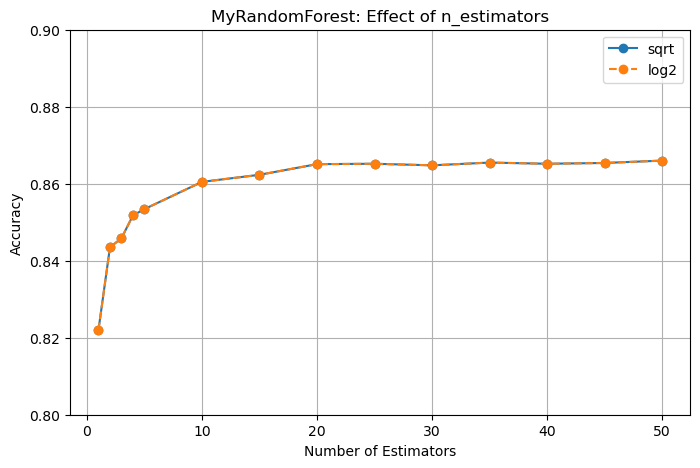

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_list, accuracies_sqrt, marker='o', linestyle='-', label='sqrt')
plt.plot(n_estimators_list, accuracies_log2, marker='o', linestyle='--', label='log2')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('MyRandomForest: Effect of n_estimators')
plt.ylim(0.80, 0.90)  # 视情况调整一下上下界，让变化更清晰
plt.legend()
plt.grid(True)
plt.show()

#### 属性特征数量对性能的影响

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 特征总数
n_features = X_train.shape[1]      # Adult 是 14
feature_nums = list(range(1, n_features + 1))

n_estimators_fixed = 5         # 固定学习器数量

accs_feat = []

for k in feature_nums:
    rf = MyRandomForestClassifier(
        n_estimators=n_estimators_fixed,
        max_depth=10,           
        max_features=k,           
        bootstrap=True,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=1
    )
    print(f"Handling Case {k}")
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accs_feat.append(acc)

print("feature_nums:", feature_nums)
print("accs_feat   :", accs_feat)


Handling Case 1
Handling Case 2
Handling Case 3
Handling Case 4
Handling Case 5
Handling Case 6
Handling Case 7
Handling Case 8
Handling Case 9
Handling Case 10
Handling Case 11
Handling Case 12
Handling Case 13
Handling Case 14
feature_nums: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
accs_feat   : [0.7983416931108609, 0.8520831200737026, 0.8576108097041663, 0.8606817483877572, 0.8617053946156208, 0.8606817483877572, 0.8615006653700481, 0.8627290408434845, 0.8615006653700481, 0.8608864776333299, 0.8604770191421844, 0.8621148531067663, 0.8631384993346299, 0.8606817483877572]


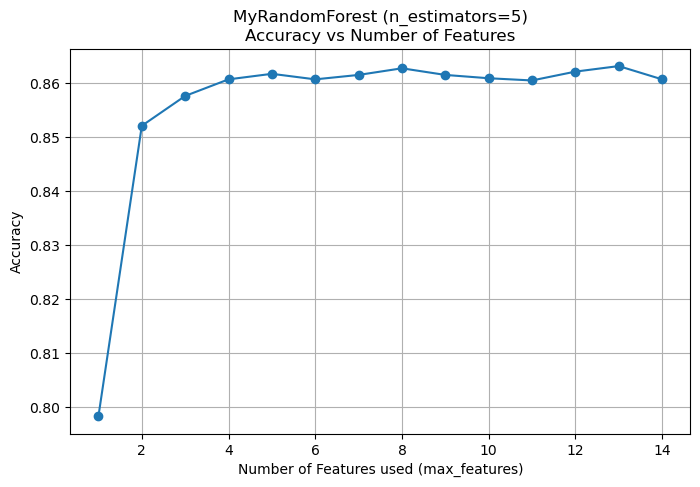

In [33]:
plt.figure(figsize=(8, 5))
plt.plot(feature_nums, accs_feat, marker='o')
plt.xlabel('Number of Features used (max_features)')
plt.ylabel('Accuracy')
plt.title(f'MyRandomForest (n_estimators={n_estimators_fixed})\nAccuracy vs Number of Features')
plt.grid(True)
plt.show()

## 五、小结

通过本实验我们：

- 从零实现了 CART 决策树与基于它的随机森林算法；
- 在 Adult 数据集上验证了模型性能；
- 使用可视化对比了不同模型与参数设置对分类性能的影响。
